# Introduction to Convolutional Neural Networks
We have been using **fully connected networks** (FCNs) to classify the MNIST dataset, and in the last assignment we designed a network which could do this with an accuracy of around 98%.   Convolutional Neural Networks, or Convnets, or CNNS (fake networks!), are another even more powerful tool for classifying images such as MNIST.   

# Errors?
Check to see that the **kernel** is correct (Python 6.6/Conda 5.2).

Check that you have the correct version of keras (2.2.4) and tensorflow-gpu (1.9.0).

You can do this one of two ways:

In [1]:
import keras
import tensorflow
print("keras",keras.__version__)
print("tensorflow",tensorflow.__version__)

Using TensorFlow backend.


keras 2.3.0
tensorflow 1.14.0


In [2]:
!pip list

Package                            Version   
---------------------------------- ----------
absl-py                            0.8.0     
alabaster                          0.7.11    
anaconda-clean                     1.0       
anaconda-client                    1.7.1     
anaconda-navigator                 1.8.7     
anaconda-project                   0.8.2     
appdirs                            1.4.3     
argcomplete                        1.9.4     
asn1crypto                         0.24.0    
astor                              0.8.0     
astroid                            2.0.4     
astropy                            3.0.4     
atomicwrites                       1.1.5     
attrs                              18.1.0    
Automat                            0.7.0     
Babel                              2.6.0     
backcall                           0.1.0     
backports.shutil-get-terminal-size 1.0.0     
backports.weakref                  1.0.post1 
beautifulsoup4                    

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Pull in the MNIST data

In [3]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

short = False
if short:
    train_images = train_images[:7000,:]
    train_labels = train_labels[:7000]
    test_images = test_images[:3000,:]
    test_labels = test_labels[:3000]
#
print("Train info",train_images.shape, train_labels.shape)
print("Test info",test_images.shape, test_labels.shape)
train_images = train_images.reshape((train_images.shape[0],28*28))
train_images = train_images.astype('float32')/255

test_images = test_images.reshape((test_images.shape[0],28*28))
test_images = test_images.astype('float32')/255
from keras.utils import to_categorical

train_labels_cat = to_categorical(train_labels)
test_labels_cat = to_categorical(test_labels)


Train info (60000, 28, 28) (60000,)
Test info (10000, 28, 28) (10000,)


# Run on the test set using our previous network
You might ask, what do Convnets do that FCNs can't?

To understand this, let's take another look at our MNIST FCN.  If you have not already, examine and run the jupyter notebook in assignment10_prep called **train_fcn_model_mnist.ipynb**.   After you run this, you will have a stored version of the compiled and fit FCN called **fully_trained_model_fcn.h5**.

**Then** you can run the code below (which loads in the network that train_fcn_model_mnist.ipynb trains).

We should get around 98% (will vary depending on the randomly initialized weights).

In [4]:
from keras.models import load_model
network_name = 'fully_trained_model_fcn.h5'
trained_network = load_model(network_name)

## A method to get performance numbers
The following method will be helpful later to get loss, accuracy, and the confusion matrix for our network.

In [5]:
import numpy as np
#
# Used to implement the multi-dimensional counter we need in the performance class
from collections import defaultdict
def autovivify(levels=1, final=dict):
    return (defaultdict(final) if levels < 2 else
            defaultdict(lambda: autovivify(levels-1, final)))
def getPerformance(network,images,labels_cat,labels):
#
# Get the overall performance for the test sample
    loss, acc = network.evaluate(images,labels_cat)
#
# Get the individual predictions for each sample in the test set
    predictions = network.predict(images)
#
# Get the max probabilites for each rows
    probs = np.max(predictions, axis = 1)
#
# Get the predicted classes for each row
    classes = np.argmax(predictions, axis = 1)
#
# Now loop over the first twenty samples and compare truth to prediction
#print("Label\t Pred\t Prob")
#for label,cl,pr in zip(smear_labels[:20],classes[:20],probs[:20]):
#    print(label,'\t',cl,'\t',round(pr,3))
#
# Get confustion matrix
    cf = autovivify(2,int)
    for label,cl in zip(labels,classes):
        cf[label][cl] += 1
#
    return loss,acc,cf

In [6]:
loss,acc,cf = getPerformance(trained_network,test_images,test_labels_cat,test_labels)
print("   Results")
print("   Loss,acc",round(loss,4),round(acc,4))
for trueClass in range(10):
    print("   True: ",trueClass,end="")
    for predClass in range(10):
        print(" \t",cf[trueClass][predClass],end="")
    print()
print()


10000/10000 [==============================] - 0s 35us/step
   Results
   Loss,acc 0.0623 0.9824
   True:  0 	 974 	 1 	 1 	 0 	 0 	 1 	 1 	 1 	 1 	 0
   True:  1 	 1 	 1125 	 2 	 1 	 0 	 1 	 2 	 1 	 2 	 0
   True:  2 	 3 	 0 	 1012 	 2 	 1 	 0 	 2 	 3 	 8 	 1
   True:  3 	 0 	 0 	 4 	 989 	 0 	 4 	 0 	 4 	 3 	 6
   True:  4 	 1 	 0 	 2 	 1 	 961 	 0 	 4 	 2 	 1 	 10
   True:  5 	 2 	 0 	 0 	 9 	 1 	 875 	 2 	 1 	 1 	 1
   True:  6 	 5 	 2 	 1 	 1 	 1 	 7 	 940 	 0 	 1 	 0
   True:  7 	 0 	 1 	 6 	 2 	 1 	 1 	 0 	 1009 	 3 	 5
   True:  8 	 1 	 0 	 2 	 3 	 2 	 5 	 1 	 2 	 954 	 4
   True:  9 	 3 	 2 	 0 	 4 	 6 	 5 	 0 	 3 	 1 	 985



# Can we improve on this?
When we ask about how we might improve on this performance, we should think about a few things:
1.  How big is our network?   Does it scale to images larger than our 28x28x1 digit images?
2.  How sensitive is our network to small (or even large) changes in our inputs?
3.  Even if the previous two points are a problem, we can still ask if it is possible to improve our performance over the FCN.

## How big is our network
Keras gives us a tool to get summary information about our network:

In [7]:
print(trained_network.input)
print(trained_network.output)
print(trained_network.summary())

Tensor("dense_1_input:0", shape=(?, 784), dtype=float32)
Tensor("dense_2/Softmax:0", shape=(?, 10), dtype=float32)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 400)               314000    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                4010      
Total params: 318,010
Trainable params: 318,010
Non-trainable params: 0
_________________________________________________________________
None


## Calculating the Number of parameters
Notice that the two layers are called **dense**: these are fully connected layers, meaning there is a connection from every output of one layer to every input of the next layer.   Here is how we get the parameter counts:
1.  dense_1 (the "_1" is just a label from when the network was created, it has no significance): We have 784 inputs each connected to 400 hidden nodes: 784*400=313600 parameters, plus another 400 "bias" parameters (1 for each node) which gives us a total of 314,000 parameters for the hidden layer.
2.  dense_2: we have 400 inputs (one each from the hidden layer) connected to 10 outputs: 400*10 + 10(bias)=4010 parameters for the output layer.

So we have 318,010 total parameters for a network which is used to classify small 28x28x1 greyscale images.   If we went to megapixel color images, we would have 1000x1000x3 = 3,000,000 input pixels, and if we have a 400 node hidden layer (which is probably too small), we end up with more than 1.2 billion parameters.... this does not scale!

## Sensitivity to variations in the input
The types of variations we want to consider include:
1.  Shifts of the input image (up/down and/or right/left).
2.  Scaling of the input image (making it bigger or smaller (still within the 28x28 pixel window).
3.  Rotations of the input image.
We could also include shearing of the input image, but for now lets just consider the first 3.   

Keras includes a method for performing all of these operations on an image.   Let's define a method to do this, using a single image as an input, and also define a method to display the image:

In [8]:
import keras.preprocessing.image as kpi
import matplotlib.pyplot as plt
import numpy as np

data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
image_datagen = kpi.ImageDataGenerator(**data_gen_args)

def transform_image(img,tx=0,ty=0,zoom=1.0,rotation=0.0,shear=0.0):
    transform_parameters = {}
    orig_image = np.array(img, copy=True).reshape(28,28,1)
    transform_parameters['theta'] = rotation
    transform_parameters['zx'] = zoom
    transform_parameters['zy'] = zoom
    transform_parameters['tx'] = tx
    transform_parameters['ty'] = ty
    transform_parameters['shear'] = shear
    orig_image = image_datagen.apply_transform(x=orig_image, transform_parameters=transform_parameters)
    return orig_image

def plot_image(img):
    one_image = img.reshape(28,28)
    plt.imshow(one_image, cmap='hot')
    plt.colorbar()
    plt.show()


## TASK 1: Pick a random image from our test dataset, and do the following:
1.  Rotate 45 degrees.
2.  Rotate 45 degrees plus zoom out (make the digit smaller)
3.  Rotate 45 degrees plus zoom out plus translate the image to the upper corner.

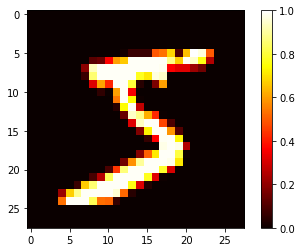

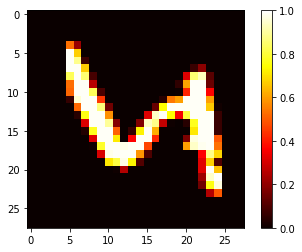

In [14]:
# Your code here!
plot_image(train_images[0])
img = transform_image(train_images[0], rotation = 90)
plot_image(img)

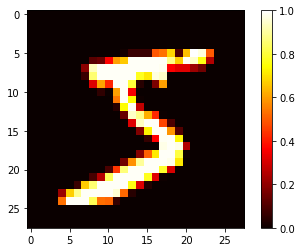

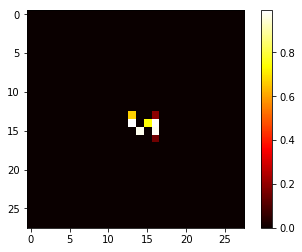

In [18]:
# Your code here!
plot_image(train_images[0])
img = transform_image(train_images[0], rotation = 90, zoom = 5)
plot_image(img)

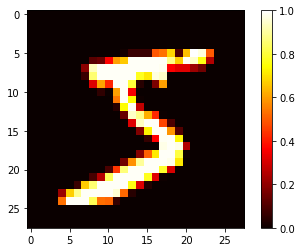

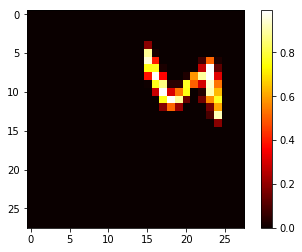

In [29]:
# Your code here!
plot_image(train_images[0])
img = transform_image(train_images[0], rotation = 90,zoom = 2, tx = 10, ty = -10)
plot_image(img)

## Stability of the FCN to Variations in the input
We are now ready to systematically answer the question: how well does the FCN handle images that are slight (or not-so-slight) variations of the data it was trained on.   

Here is what we will do: 
1.  Loop over every image in the test set
2.  Choose a random +/- shift (in x and y) from a subset (0-4 pixels in increments of 1).
3.  Randomly shift the image over that shift.
4.  Store the transformed image in a list
When we are done, we will run that list of images through our original FCN and note the performance, comparing it to the original performance.

In [30]:
import random
import numpy as np

for shift in [0,1,2,3,4]:
    print()
    print("Shift ",shift)
    imgList = []
    count = 0
    for img in test_images[:]:
        if random.uniform(0.0,1.0) > 0.5:
            tx = shift
        else:
            tx = -shift
        if random.uniform(0.0,1.0) > 0.5:
            ty = shift
        else:
            ty = -shift
#        tx = random.uniform(-shift,shift)
#        ty = random.uniform(-shift,shift)
        trans_image = transform_image(img,tx=tx,ty=ty,zoom=1.0,rotation=0.0,shear=0.0)
        imgList.append(trans_image)
#
# Convert to np array
    npa_images = np.asarray(imgList, dtype=np.float32)
    npa_images = npa_images.reshape((npa_images.shape[0],28*28))
#
    smear_loss,smear_acc,smear_cf = getPerformance(trained_network,npa_images,test_labels_cat,test_labels)
    print("   Results")
    print("   Loss,acc",smear_loss,smear_acc)
    for trueClass in range(10):
        print("   True: ",trueClass,end="")
        for predClass in range(10):
            print(" \t",smear_cf[trueClass][predClass],end="")
        print()



Shift  0
10000/10000 [==============================] - 0s 29us/step
   Results
   Loss,acc 0.06230982769207913 0.9824000000953674
   True:  0 	 974 	 1 	 1 	 0 	 0 	 1 	 1 	 1 	 1 	 0
   True:  1 	 1 	 1125 	 2 	 1 	 0 	 1 	 2 	 1 	 2 	 0
   True:  2 	 3 	 0 	 1012 	 2 	 1 	 0 	 2 	 3 	 8 	 1
   True:  3 	 0 	 0 	 4 	 989 	 0 	 4 	 0 	 4 	 3 	 6
   True:  4 	 1 	 0 	 2 	 1 	 961 	 0 	 4 	 2 	 1 	 10
   True:  5 	 2 	 0 	 0 	 9 	 1 	 875 	 2 	 1 	 1 	 1
   True:  6 	 5 	 2 	 1 	 1 	 1 	 7 	 940 	 0 	 1 	 0
   True:  7 	 0 	 1 	 6 	 2 	 1 	 1 	 0 	 1009 	 3 	 5
   True:  8 	 1 	 0 	 2 	 3 	 2 	 5 	 1 	 2 	 954 	 4
   True:  9 	 3 	 2 	 0 	 4 	 6 	 5 	 0 	 3 	 1 	 985

Shift  1
10000/10000 [==============================] - 0s 32us/step
   Results
   Loss,acc 0.28704255996383726 0.9253000020980835
   True:  0 	 899 	 0 	 14 	 2 	 0 	 22 	 14 	 5 	 10 	 14
   True:  1 	 1 	 992 	 4 	 2 	 1 	 23 	 21 	 64 	 24 	 3
   True:  2 	 5 	 2 	 977 	 10 	 0 	 3 	 7 	 15 	 12 	 1
   True:  3 	 1 	 

**This is bad.** As soon as we get 2 pixels out, the performance drops by almost 30%!   So the FCN is not stable at all against small variations in input.

## Task 2: Test FCN Stability Further
Using a similar strategy as above, try the following:
1.  Rotations in the range: [0.0,20.0,40.0,60.0,80.0] (keep shifts=0)
2.  Zooms in the range[1.0,1.25,1.5,1.75,2.0] (keep shifts and rotations=0)

In [31]:
# Your code here!
import random
import numpy as np

for rot in [0.0,20.0,40.0,60.0,80.0]:
    print()
    print("Shift ",shift)
    imgList = []
    count = 0
    for img in test_images[:]:
        if random.uniform(0.0,1.0) > 0.5:
            rot = rot
        else:
            rot = -rot
#        tx = random.uniform(-shift,shift)
#        ty = random.uniform(-shift,shift)
        trans_image = transform_image(img,tx=0.0,ty=0.0,zoom=1.0,rotation=rot,shear=0.0)
        imgList.append(trans_image)
#
# Convert to np array
    npa_images = np.asarray(imgList, dtype=np.float32)
    npa_images = npa_images.reshape((npa_images.shape[0],28*28))
#
    smear_loss,smear_acc,smear_cf = getPerformance(trained_network,npa_images,test_labels_cat,test_labels)
    print("   Results")
    print("   Loss,acc",smear_loss,smear_acc)
    for trueClass in range(10):
        print("   True: ",trueClass,end="")
        for predClass in range(10):
            print(" \t",smear_cf[trueClass][predClass],end="")
        print()



Shift  4
10000/10000 [==============================] - 0s 30us/step
   Results
   Loss,acc 0.06230982769207913 0.9824000000953674
   True:  0 	 974 	 1 	 1 	 0 	 0 	 1 	 1 	 1 	 1 	 0
   True:  1 	 1 	 1125 	 2 	 1 	 0 	 1 	 2 	 1 	 2 	 0
   True:  2 	 3 	 0 	 1012 	 2 	 1 	 0 	 2 	 3 	 8 	 1
   True:  3 	 0 	 0 	 4 	 989 	 0 	 4 	 0 	 4 	 3 	 6
   True:  4 	 1 	 0 	 2 	 1 	 961 	 0 	 4 	 2 	 1 	 10
   True:  5 	 2 	 0 	 0 	 9 	 1 	 875 	 2 	 1 	 1 	 1
   True:  6 	 5 	 2 	 1 	 1 	 1 	 7 	 940 	 0 	 1 	 0
   True:  7 	 0 	 1 	 6 	 2 	 1 	 1 	 0 	 1009 	 3 	 5
   True:  8 	 1 	 0 	 2 	 3 	 2 	 5 	 1 	 2 	 954 	 4
   True:  9 	 3 	 2 	 0 	 4 	 6 	 5 	 0 	 3 	 1 	 985

Shift  4
10000/10000 [==============================] - 0s 32us/step
   Results
   Loss,acc 0.5062316453650594 0.8870000243186951
   True:  0 	 957 	 0 	 0 	 1 	 0 	 14 	 2 	 1 	 4 	 1
   True:  1 	 0 	 1042 	 7 	 6 	 8 	 7 	 2 	 2 	 60 	 1
   True:  2 	 14 	 2 	 895 	 30 	 16 	 6 	 8 	 26 	 32 	 3
   True:  3 	 5 	 0 	 1

In [32]:
# Your code here!
# Your code here!
import random
import numpy as np

for zoom in [1.0,1.25,1.5,1.75,2.0] :
    print()
    print("Shift ",shift)
    imgList = []
    count = 0
    for img in test_images[:]:
        if random.uniform(0.0,1.0) > 0.5:
            zoom = zoom
        else:
            zoom = -zoom
#        tx = random.uniform(-shift,shift)
#        ty = random.uniform(-shift,shift)
        trans_image = transform_image(img,tx=0.0,ty=0.0,zoom=zoom,rotation=0.0,shear=0.0)
        imgList.append(trans_image)
#
# Convert to np array
    npa_images = np.asarray(imgList, dtype=np.float32)
    npa_images = npa_images.reshape((npa_images.shape[0],28*28))
#
    smear_loss,smear_acc,smear_cf = getPerformance(trained_network,npa_images,test_labels_cat,test_labels)
    print("   Results")
    print("   Loss,acc",smear_loss,smear_acc)
    for trueClass in range(10):
        print("   True: ",trueClass,end="")
        for predClass in range(10):
            print(" \t",smear_cf[trueClass][predClass],end="")
        print()



Shift  4
10000/10000 [==============================] - 0s 26us/step
   Results
   Loss,acc 4.801036519622802 0.6675999760627747
   True:  0 	 957 	 1 	 1 	 1 	 0 	 10 	 4 	 4 	 2 	 0
   True:  1 	 0 	 956 	 1 	 3 	 2 	 3 	 1 	 161 	 3 	 5
   True:  2 	 6 	 2 	 597 	 6 	 7 	 46 	 7 	 51 	 290 	 20
   True:  3 	 0 	 15 	 28 	 489 	 4 	 325 	 6 	 6 	 129 	 8
   True:  4 	 0 	 78 	 68 	 49 	 560 	 27 	 109 	 14 	 70 	 7
   True:  5 	 2 	 3 	 15 	 79 	 1 	 780 	 5 	 1 	 1 	 5
   True:  6 	 5 	 4 	 5 	 47 	 4 	 38 	 478 	 26 	 1 	 350
   True:  7 	 0 	 139 	 280 	 2 	 10 	 6 	 50 	 519 	 19 	 3
   True:  8 	 1 	 4 	 40 	 55 	 0 	 4 	 1 	 3 	 863 	 3
   True:  9 	 4 	 60 	 10 	 39 	 2 	 36 	 314 	 2 	 65 	 477

Shift  4
10000/10000 [==============================] - 0s 32us/step
   Results
   Loss,acc 3.552101735305786 0.5794000029563904
   True:  0 	 917 	 1 	 2 	 4 	 12 	 1 	 38 	 3 	 0 	 2
   True:  1 	 0 	 1032 	 4 	 1 	 5 	 0 	 0 	 89 	 2 	 2
   True:  2 	 7 	 73 	 548 	 6 	 52 	 3 	 2

## Shortcomings of FCNs
We see that standard, fully-connected neural networks, although powerful, have some clear shortcomings when applied to image classification:
1.  They do not scale well.  Reasonable-sized images would require an enormous number of parameters.   This in turn would require a corresponding increase in the number of training samples in order to determine the parameters accurately.
2.  They are dependent on the specific pixel relationships within the image.   Performance degrades substantially as soon as there is a minor devation from these relationships.

Both of these issues are related: the FCN does not take advantage of the fact that - generally - in image classification, the images tend to be built from underlying common features.   In the case of MNIST images, these are the curves and lines and corners which make up the individual digits.   Convnets attempt to take advantage of these features.

# Building a Convnet
Before explaining how convnets work, lets try to build a simple network to classify MNIST images.

For comparison, we first show the code we use to build and train an FCN, followed by similar code to build and train a CNN.

In [33]:
from keras import models
from keras import layers

#
# Make sure the shape of the input is correct
train_images = train_images.reshape((train_images.shape[0],28*28))
test_images = test_images.reshape((test_images.shape[0],28*28))

fcn_network = models.Sequential()
#
# Hidden
fcn_network.add(layers.Dense(400,activation='tanh',input_shape=(28*28,)))
#
# Output
fcn_network.add(layers.Dense(10,activation='softmax'))
#
# Compile
fcn_network.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
# 
# Fit/save/print summary
history = fcn_network.fit(train_images,train_labels_cat,epochs=15,batch_size=128,validation_data=(test_images,test_labels_cat))
fcn_network.save('fully_trained_model_fcn.h5')
print(fcn_network.summary())


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 2s 36us/step - loss: 0.3321 - accuracy: 0.9039 - val_loss: 0.2308 - val_accuracy: 0.9303
Epoch 2/15
60000/60000 [==============================] - 2s 33us/step - loss: 0.1814 - accuracy: 0.9478 - val_loss: 0.1584 - val_accuracy: 0.9545
Epoch 3/15
60000/60000 [==============================] - 2s 33us/step - loss: 0.1235 - accuracy: 0.9647 - val_loss: 0.1128 - val_accuracy: 0.9658
Epoch 4/15
60000/60000 [==============================] - 2s 33us/step - loss: 0.0912 - accuracy: 0.9737 - val_loss: 0.0946 - val_accuracy: 0.9711
Epoch 5/15
60000/60000 [==============================] - 2s 33us/step - loss: 0.0694 - accuracy: 0.9800 - val_loss: 0.0895 - val_accuracy: 0.9730
Epoch 6/15
60000/60000 [==============================] - 2s 33us/step - loss: 0.0541 - accuracy: 0.9848 - val_loss: 0.0758 - val_accuracy: 0.9774
Epoch 7/15
60000/60000 [==============================] - 2s 33us/st

In [34]:
from keras import models
from keras import layers
#
# Make sure the shape of the input is correct (the last ",1" is the number of "channels"=1 for grayscale)
train_images = train_images.reshape((train_images.shape[0],28,28,1))
test_images = test_images.reshape((test_images.shape[0],28,28,1))
#
cnn_network = models.Sequential()
#
# First convolutional layer
cnn_network.add(layers.Conv2D(30,(5,5),activation='relu',input_shape=(28,28,1)))
# Pool
cnn_network.add(layers.MaxPooling2D((2,2)))
#
# Second convolutional layer
cnn_network.add(layers.Conv2D(25,(5,5),activation='relu'))
# Pool
cnn_network.add(layers.MaxPooling2D((2,2)))
#
# Connect to a dense output layer - just like an FCN
cnn_network.add(layers.Flatten())
cnn_network.add(layers.Dense(64,activation='relu'))
cnn_network.add(layers.Dense(10,activation='softmax'))
#
# Compile
cnn_network.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
#
# Fit/save/print summary
history = cnn_network.fit(train_images,train_labels_cat,epochs=5,batch_size=256,validation_data=(test_images,test_labels_cat))
cnn_network.save('fully_trained_model_cnn.h5')
print(cnn_network.summary())



Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 26s 437us/step - loss: 0.3492 - accuracy: 0.8935 - val_loss: 0.1216 - val_accuracy: 0.9603
Epoch 2/5
60000/60000 [==============================] - 26s 433us/step - loss: 0.0915 - accuracy: 0.9721 - val_loss: 0.0635 - val_accuracy: 0.9812
Epoch 3/5
60000/60000 [==============================] - 26s 432us/step - loss: 0.0592 - accuracy: 0.9817 - val_loss: 0.0448 - val_accuracy: 0.9859
Epoch 4/5
60000/60000 [==============================] - 26s 434us/step - loss: 0.0439 - accuracy: 0.9863 - val_loss: 0.0392 - val_accuracy: 0.9876
Epoch 5/5
60000/60000 [==============================] - 26s 428us/step - loss: 0.0350 - accuracy: 0.9891 - val_loss: 0.0328 - val_accuracy: 0.9900
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 30)        

In [35]:
#
# Get the overall performance for the test sample
test_loss, test_acc = cnn_network.evaluate(test_images,test_labels_cat)
print("Test sample loss: ",test_loss, "; Test sample accuracy: ",test_acc)


10000/10000 [==============================] - 2s 154us/step
Test sample loss:  0.03280552174481563 ; Test sample accuracy:  0.9900000095367432


## Comparison of CNN and FCN
There are a couple of things to notice when comparing the output from the two code blocks above:
1.  The performance of the CNN is better than the FCN after 5 epochs.  A careful examination of the training set accuracies reveals that the CNN is still undertrained (and so can perform better if we increase the number of epochs).
2.  The number of parameters needed to specify the CNN is 40.3k, about 7 times smaller than the FCN!
3.  The training time per step is much longer (about 10x) for the CNN than it is for the FCN.

## Task 3: Test CNN Stability 
What we don't know yet, is how stable the CNN is to variations in the input images.
Using a similar strategy as we used above for the FCN, calaculate the performance under the following variations:
1.  Shifts in the range [0,1,2,3,4]
2.  Rotations in the range: [0.0,20.0,40.0,60.0,80.0] (keep shifts=0)
3.  Zooms in the range[1.0,1.25,1.5,1.75,2.0] (keep shifts and rotations=0)

In [ ]:
import random
import numpy as np

for zoom in [1.0,1.25,1.5,1.75,2.0] :
    print()
    imgList = []
    count = 0
    for img in test_images[:]:
        if random.uniform(0.0,1.0) > 0.5:
            zoom = zoom
        else:
            zoom = -zoom
#        tx = random.uniform(-shift,shift)
#        ty = random.uniform(-shift,shift)
        trans_image = transform_image(img,tx=0.0,ty=0.0,zoom=zoom,rotation=0.0,shear=0.0)
        imgList.append(trans_image)
#
# Convert to np array
    npa_images = np.asarray(imgList, dtype=np.float32)
    npa_images = npa_images.reshape((npa_images.shape[0],28,28,1))

#
    smear_loss,smear_acc,smear_cf = getPerformance(cnn_network,npa_images,test_labels_cat,test_labels)
    print("   Results")
    print("   Loss,acc",smear_loss,smear_acc)
    for trueClass in range(10):
        print("   True: ",trueClass,end="")
        for predClass in range(10):
            print(" \t",smear_cf[trueClass][predClass],end="")
        print()



10000/10000 [==============================] - 2s 155us/step
   Results
   Loss,acc 3.592674181556702 0.6984999775886536
   True:  0 	 962 	 0 	 1 	 0 	 0 	 4 	 8 	 1 	 0 	 4
   True:  1 	 1 	 1087 	 0 	 3 	 0 	 1 	 0 	 33 	 9 	 1
   True:  2 	 10 	 2 	 654 	 2 	 0 	 12 	 5 	 65 	 282 	 0
   True:  3 	 4 	 0 	 3 	 515 	 1 	 192 	 42 	 1 	 246 	 6
   True:  4 	 1 	 50 	 8 	 25 	 549 	 13 	 261 	 24 	 44 	 7
   True:  5 	 2 	 2 	 1 	 43 	 2 	 811 	 5 	 0 	 2 	 24
   True:  6 	 7 	 1 	 0 	 9 	 1 	 24 	 479 	 27 	 0 	 410
   True:  7 	 3 	 125 	 238 	 2 	 5 	 1 	 102 	 531 	 21 	 0
   True:  8 	 3 	 2 	 11 	 30 	 0 	 0 	 1 	 0 	 920 	 7
   True:  9 	 0 	 16 	 2 	 24 	 1 	 13 	 447 	 2 	 27 	 477

10000/10000 [==============================] - 2s 154us/step
